# Julia 深度學習：類神經網路模型簡介

## 作業 032：訓練 MLP 學習門牌號碼資料集

訓練一個 MLP 模型來學習門牌號碼資料集。

注意：MLP 模型的能力有限，可能會導致訓練起來效果不佳。

注意：近期 Flux 正在持續更新，請確保您的 Julia 在 v1.3 版以上，以及 Flux 在 v0.10.4 以上或是最新版。

In [1]:
using Flux
using Flux.Data: DataLoader
using Flux: @epochs, onecold, onehotbatch, throttle, logitcrossentropy
using MLDatasets
using Statistics
using ImageCore

## 讀取資料

呼叫 SVHN2 資料集的過程中，會先去檢查以前是否有下載過，如果是第一次下載，過程中會詢問是否下載資料集，請回答 `y`。整個資料集的大小約為 1.6 GB，下載時間可能會稍久，請耐心等候。

In [2]:
SVHN2.classnames()

10-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7
 8
 9
 0

## Visualize the digit data

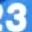

In [3]:
SVHN2.convert2image(SVHN2.traindata(4)[1])

In [4]:
train_X, train_y = SVHN2.traindata(Float32)
test_X,  test_y  = SVHN2.testdata(Float32)

(Float32[0.14901961 0.15294118 … 0.19607843 0.1882353; 0.15294118 0.15294118 … 0.2 0.1882353; … ; 0.16470589 0.16862746 … 0.1764706 0.17254902; 0.15294118 0.15294118 … 0.16470589 0.16470589]

Float32[0.40392157 0.40784314 … 0.45882353 0.4509804; 0.40784314 0.40784314 … 0.4627451 0.4509804; … ; 0.40392157 0.39607844 … 0.45490196 0.4509804; 0.38039216 0.38039216 … 0.44313726 0.44313726]

Float32[0.23529412 0.23921569 … 0.29803923 0.2901961; 0.23921569 0.23921569 … 0.3019608 0.2901961; … ; 0.24313726 0.24705882 … 0.28235295 0.2784314; 0.22352941 0.22352941 … 0.27058825 0.2784314]

Float32[0.5058824 0.5254902 … 0.5411765 0.5137255; 0.49803922 0.52156866 … 0.50980395 0.47843137; … ; 0.48235294 0.49411765 … 0.39607844 0.43529412; 0.48235294 0.49019608 … 0.4392157 0.48235294]

Float32[0.5568628 0.5882353 … 0.59607846 0.5686275; 0.56078434 0.58431375 … 0.5647059 0.53333336; … ; 0.5254902 0.5372549 … 0.41960785 0.4627451; 0.5294118 0.5372549 … 0.4627451 0.50980395]

Float32[0.6 0.627451 … 0.647

In [5]:
train_X = Flux.flatten(train_X)
test_X = Flux.flatten(test_X)
train_y = onehotbatch(train_y, 1:10)
test_y = onehotbatch(test_y, 1:10)

10×26032 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  1  0  0  1  0  1  1  0  0  0  0  …  1  0  1  0  1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  1  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  0  0  0  0  0

In [6]:
batchsize = 512
train = DataLoader(train_X, train_y, batchsize=batchsize, shuffle=true)
test = DataLoader(test_X, test_y, batchsize=batchsize)

DataLoader((Float32[0.14901961 0.5058824 … 0.3764706 0.39607844; 0.15294118 0.49803922 … 0.38039216 0.39215687; … ; 0.2784314 0.5647059 … 0.2901961 0.19607843; 0.2784314 0.6117647 … 0.26666668 0.19607843], Bool[0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 512, 26032, true, 26032, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  26023, 26024, 26025, 26026, 26027, 26028, 26029, 26030, 26031, 26032], false)

In [7]:
model = Chain(
  Dense(3072, 1024, relu),
  Dense(1024, 256, relu),
  Dense(256, 10),
  softmax)

Chain(Dense(3072, 1024, relu), Dense(1024, 256, relu), Dense(256, 10), softmax)

## Define loss function

In [8]:
loss(x, y) = logitcrossentropy(model(x), y)

loss (generic function with 1 method)

## Callback function

In [9]:
function test_loss()
    l = 0f0
    for (x, y) in test
        l += loss(x, y)
    end
    l/length(test)
end

test_loss (generic function with 1 method)

In [10]:
evalcb() = @show(test_loss())

evalcb (generic function with 1 method)

In [11]:
epochs = 10
@epochs epochs Flux.train!(loss, params(model), train, ADAM(0.005), cb=throttle(evalcb, 10))

┌ Info: Epoch 1
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.248131f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 2
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 3
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 4
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 5
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 6
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 7
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 8
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 9
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


┌ Info: Epoch 10
└ @ Main C:\Users\h1646\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2652242f0
test_loss() = 2.2652242f0
test_loss() = 2.2652242f0


In [12]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [13]:
accuracy(test_X, test_y)

0.1958743085433313